# Stepik ML contest

## Цели исследования курса Stepik, как отдельного продукта: 
* узнать почему пользователи Stepik не заканчивают курсы до конца;
* выяснить, как предсказать, что пользователь бросит курс;
* какими основными паттернами поведения взаимодействия с контентом курса обладают пользователи, которые успешно заканчивают курс, относительно тех, кто их бросает. 

## Задачи для решения
- подготовить данные к исследованию;
- определить срок отсутвия пользователя, покинувшего курс;
- определить срок успешного завершения курса;
- подготовить данные к обучению на модели.

## Входные данные

- лог сервера с данными о действих пользователя на курсе (файл `event_data_train.zip`)  
`step_id` - номер задания на курсе;  
`timestamp` - время выполнения задания;  
`action` - действие пользователя;  
`user_id` - идентификационный номер пользователя. 

- лог сервера с данными об успешности выполнения заданий на курсе (файл `submissions_data_train.zip`)  
`step_id` - номер задания на курсе;  
`timestamp` - время выполнения задания;  
`submission_status` - корректность пользователя;  
`user_id` - идентификационный номер пользователя.

### 1. Изучение и подготовка данных

#### Run until 1

In [1]:
# run до 1 раздела
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize': (9,6)}) #увеличение дефолтного размера графика

events_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/event_data_train.zip')
submissions_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/submissions_data_train.zip')

n:\anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#### 1.1 Датасет **events_data**

In [7]:
events_data.head(10)

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632
5,32811,1434340895,passed,17632
6,32929,1434340921,discovered,17632
7,32929,1434340921,viewed,17632
8,32929,1434340939,started_attempt,17632
9,32929,1434340944,passed,17632


In [8]:
events_data.action.unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

In [19]:
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')

In [20]:
events_data.head()

,step_id,timestamp,action,user_id,date
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48
1,32815,1434340848,passed,17632,2015-06-15 04:00:48
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35


In [22]:
events_data.date.max()

Timestamp('2018-05-19 23:33:31')

In [24]:
events_data['day'] = events_data.date.dt.date

In [25]:
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


<AxesSubplot:xlabel='day'>

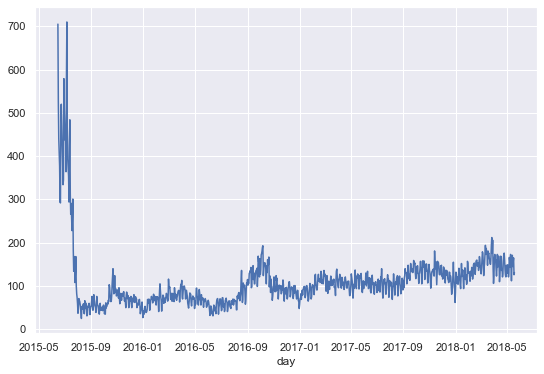

In [31]:
events_data.groupby('day') \
    .user_id.nunique().plot() #распределение активных пользователей по дням

Описание:
* после старта курса изначально записалось много человек;
* потом активность курса упала;
* с течением времени популярность курса постепенно возрастала;
* в данных нет очевидных выбросов.

Построим распределение пользователей по количеству баллов, набранных за курс

**Решение 1** - ошибочно

Пользователи набирают баллы в том случае, когда у них в статусе "пройден" хотя бы 1 степ.\
Количество *'passed'* = количество *баллов*. 

<AxesSubplot:>

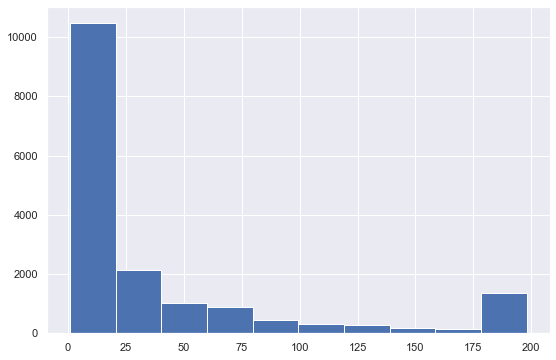

In [36]:
events_data[events_data.action == 'passed'] \
    .groupby('user_id', as_index=False) \
    .agg({'step_id': 'count'}) \
    .rename(columns={'step_id': 'passed_steps'}).passed_steps.hist()

**Ошибка:** мы отбросили пользователей, которые не решили ни одного "степа" - *'passed'*.\
Однако категория пользователей, у которых *'passed'* = 0 также имеет количество *баллов* и оно равно 0 (они совершили действие на курсе - *'viewed'*, но за это не получили баллов).

Для проверки убедимся, что по текущим условиям минимальное число учитываемых пользователей с *'passed'* начинается с 1, а не с 0:

In [37]:
events_data[events_data.action == 'passed'] \
    .groupby('user_id', as_index=False) \
    .agg({'step_id': 'count'}) \
    .rename(columns={'step_id': 'passed_steps'}).passed_steps.min()

1

**Решение 2** - верно

Перевернем таблицу через *pivot_table*

In [40]:
events_data.pivot_table(index='user_id', 
                        columns='action', 
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index().head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


Теперь мы можем увидеть, какие действия совершал каждый пользователь на курсе

<AxesSubplot:>

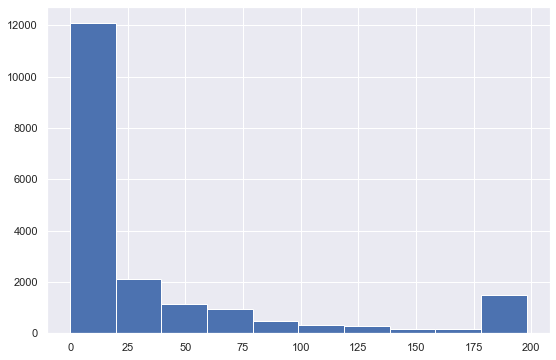

In [47]:
events_data.pivot_table(index='user_id', 
                        columns='action', 
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index().discovered.hist()

Сравнив гистограммы с обоими решениями мы можем увидеть отличие максимального числа пользователей между 1 и 2 решениями: за первый период ~10000 и ~12000.\
Это означает, что мы оставили без внимания значительную часть данных (~2000 пользователей с 0 баллов), способную повлиять на конечный результат исследования. 

Убедившись в верности суждений, охраняем результат в переменную

In [125]:
#присвоим в отдельную переменную для дальнейшего использования
users_events_data = events_data.pivot_table(index='user_id', 
                        columns='action', 
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()

In [127]:
users_events_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


#### 1.2 Датасет **submissions_data**

Аналогичным образом с `events_data` обрабаотываем датасет `submissions_data`

In [50]:
submissions_data.head(10)

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853
5,31976,1434348188,correct,15853
6,31976,1478852055,correct,15853
7,31977,1434347371,correct,15853
8,31978,1434349981,correct,15853
9,31979,1434446091,correct,15853


In [51]:
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')

In [55]:
submissions_data['day'] = submissions_data.date.dt.date

In [56]:
submissions_data.head(10)

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15
5,31976,1434348188,correct,15853,2015-06-15 06:03:08,2015-06-15
6,31976,1478852055,correct,15853,2016-11-11 08:14:15,2016-11-11
7,31977,1434347371,correct,15853,2015-06-15 05:49:31,2015-06-15
8,31978,1434349981,correct,15853,2015-06-15 06:33:01,2015-06-15
9,31979,1434446091,correct,15853,2015-06-16 09:14:51,2015-06-16


In [118]:
users_scores = submissions_data.pivot_table(index='user_id', 
                        columns='submission_status', 
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()

In [119]:
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


### 2. Определение неактивных пользователей

#### Run until 2

In [ ]:
# run до 1 раздела
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize': (9,6)}) #увеличение дефолтного размера графика
events_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/event_data_train.zip')
submissions_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/submissions_data_train.zip')

In [3]:
# run до 2 раздела
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')
events_data['day'] = events_data.date.dt.date

#присвоим в отдельную переменную для дальнейшего использования
users_events_data = events_data.pivot_table(index='user_id', 
                        columns='action', 
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()

submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')
submissions_data['day'] = submissions_data.date.dt.date
users_scores = submissions_data.pivot_table(index='user_id', 
                        columns='submission_status', 
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()


#### 2.1 Период бездействия пользователей

Для этого определим наличие активности по совершению любого из действий в течение дня:\
соберем все уникальные timestamp по дням, в которые он был на курсе и посмотрим на перерывы между ними

In [62]:
gap_data = events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list) \
    .apply(np.diff).values

In [63]:
gap_data = pd.Series(np.concatenate(gap_data, axis=0))

In [67]:
gap_data = gap_data / (24*60*60)

<AxesSubplot:>

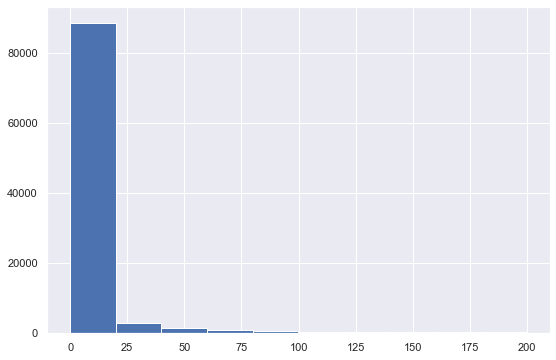

In [72]:
gap_data[gap_data < 200].hist()

In [73]:
gap_data.quantile(0.95)

59.760440972222156

Из этого следует, что только 5% пользователей возвращаются на курс после перерыва в ~60 дней

In [74]:
gap_data.quantile(0.90)

18.325995370370403

Примем **значение** между 90-ым и 95-ым процентилем, равным **30 дням**, как достаточный период для того, чтобы считать пользователя **покинувшем** курс.

Таким образом, мы сформировали свои условия для  определения пользователя, покинувшего курс:
* он отсутствует больше, чем 30 дней;
* курс не пройден до конца.

#### 2.2 Применение необходимых и достаточных условий

In [107]:
events_data.tail()

,step_id,timestamp,action,user_id,date,day
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19
3480702,33892,1526772811,viewed,18526,2018-05-19 23:33:31,2018-05-19


Последний день курса - 19 мая 2018, которому соответсвует последняя строка с *'timestamp'* = 1526772811

In [113]:
now = 1526772811 #последняя секунда последнего дня на момент сбора данных
drop_out_threshold = 30 * 24 * 60 * 60 #30 дней переведенные в секунды - формат timestamp

Создадим таблицу `users_data` пользователей с последней меткой `timestamp`

In [109]:
users_data = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'max'})\
    .rename(columns={'timestamp': 'last_timestamp'})

Добавим поле `is_gone_users`, оперделяющее пользователей, отсутсвующих более 30 дней (покинувшие курс)

In [115]:
users_data['is_gone_users'] = (now - users_data.last_timestamp) > drop_out_threshold

In [116]:
users_data

,user_id,last_timestamp,is_gone_users
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True
...,...,...,...
19229,26790,1517495987,True
19230,26793,1510225034,True
19231,26794,1512035039,True
19232,26797,1509995096,True


Подготовим условие, что для будущего подсчета пользователей, которые не завершили курс (добавим к таблице с баллами)

In [120]:
users_data = users_data.merge(users_scores, on='user_id', how='outer')

In [122]:
users_data = users_data.fillna(0)

In [123]:
users_data

,user_id,last_timestamp,is_gone_users,correct,wrong
0,1,1472827464,True,0.0,0.0
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,0.0,0.0
...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0
19230,26793,1510225034,True,0.0,0.0
19231,26794,1512035039,True,33.0,9.0
19232,26797,1509995096,True,2.0,0.0


In [128]:
users_data = users_data.merge(users_events_data, how='outer')

In [129]:
users_data.head()

,user_id,last_timestamp,is_gone_users,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,True,0.0,0.0,1,0,0,1
1,2,1519226966,True,2.0,0.0,9,9,2,10
2,3,1444581588,True,29.0,23.0,91,87,30,192
3,5,1499859939,True,2.0,2.0,11,11,4,12
4,7,1521634660,True,0.0,0.0,1,1,0,1


Добавим число уникальных дней пользователя на курсе

In [131]:
users_days = events_data.groupby('user_id').day.nunique().to_frame().reset_index()

In [134]:
users_data = users_data.merge(users_days, how='outer')

In [135]:
users_data

,user_id,last_timestamp,is_gone_users,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0,8,8,1,9,4
19230,26793,1510225034,True,0.0,0.0,1,0,1,1,1
19231,26794,1512035039,True,33.0,9.0,69,69,34,180,9
19232,26797,1509995096,True,2.0,0.0,10,10,2,13,2


#### 2.3 Проверка целостности данных после преобразования

In [137]:
users_data.user_id.nunique() == events_data.user_id.nunique()

True

Проверим пользователей на завершенность курса\
Допустим, пройденным курс считается при получении 170 баллов (количество степов *'passed'* = 170)

In [138]:
users_data['passed_course'] = users_data.passed > 170

In [139]:
users_data

,user_id,last_timestamp,is_gone_users,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False
...,...,...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0,8,8,1,9,4,False
19230,26793,1510225034,True,0.0,0.0,1,0,1,1,1,False
19231,26794,1512035039,True,33.0,9.0,69,69,34,180,9,False
19232,26797,1509995096,True,2.0,0.0,10,10,2,13,2,False


In [140]:
users_data.groupby('passed_course').count()

,user_id,last_timestamp,is_gone_users,correct,wrong,discovered,passed,started_attempt,viewed,day
passed_course,,,,,,,,,,
False,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809
True,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425


In [143]:
100 * 1425 / 17809 # % количества людей, прошедших курс

8.001572238755685

### 3. Подготовка к обучению

#### Run until 3

In [1]:
# run до 1 раздела
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize': (9,6)}) #увеличение дефолтного размера графика
events_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/event_data_train.zip')
submissions_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/submissions_data_train.zip')

n:\anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# run до 2 раздела
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')
events_data['day'] = events_data.date.dt.date

#присвоим в отдельную переменную для дальнейшего использования
users_events_data = events_data.pivot_table(index='user_id', 
                        columns='action', 
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()

submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')
submissions_data['day'] = submissions_data.date.dt.date
users_scores = submissions_data.pivot_table(index='user_id', 
                        columns='submission_status', 
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()

In [3]:
# run до 3 раздела
gap_data = events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list) \
    .apply(np.diff).values
gap_data = pd.Series(np.concatenate(gap_data, axis=0))
gap_data = gap_data / (24*60*60)

now = 1526772811 #последняя секунда последнего дня на момент сбора данных
drop_out_threshold = 30 * 24 * 60 * 60 #30 дней переведенные в секунды - формат timestamp
users_data = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'max'})\
    .rename(columns={'timestamp': 'last_timestamp'})
users_data['is_gone_users'] = (now - users_data.last_timestamp) > drop_out_threshold
users_data = users_data.merge(users_scores, on='user_id', how='outer')
users_data = users_data.fillna(0)
users_data = users_data.merge(users_events_data, how='outer')
users_days = events_data.groupby('user_id').day.nunique().to_frame().reset_index()
users_data = users_data.merge(users_days, how='outer')

users_data['passed_course'] = users_data.passed > 170


#### 3.1. Определение временных интервалов

Можем ли мы анализируя поведение пользователя за первые N дней предсказать уйдет ли он или закончит курс до конца

In [4]:
users_data.head()

,user_id,last_timestamp,is_gone_users,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


Узнаем, сколько уникальных дней пользователь потратил на прохождение курса

<AxesSubplot:>

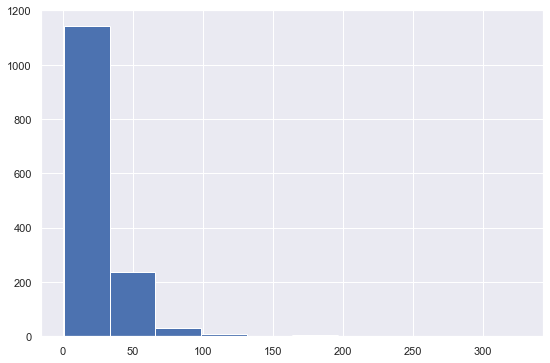

In [5]:
users_data[users_data.passed_course].day.hist()

In [53]:
users_data[users_data.passed_course].day.median()

20.0

Выяснили, что среднем для успешного окончания курса пользователю требуется **20 дней**

Для посчета через сколько N дней пользователь покинет курс создадим переменную с минимальным таймстэмпом - время первого действия на курсе

In [6]:
user_min_time = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'min'}) \
    .rename({'timestamp': 'min_timestamp'}, axis=1)

In [7]:
user_min_time.head()

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660


In [8]:
users_data = users_data.merge(user_min_time, how='outer')

In [9]:
users_data.head()

,user_id,last_timestamp,is_gone_users,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660


Оптимальным промежутком для определения поведения были выбраны 3 дня

Таким образом оставим данные о пользователях только за их первые 3 суток на курсе с момента первого действия

In [10]:
ev_d = events_data.merge(user_min_time, how="outer")

three_days = 3 * 24 * 60 * 60

events_data_train = ev_d[ev_d.timestamp <= ev_d.min_timestamp + three_days]

In [11]:
events_data_train.groupby('user_id').day.nunique().max()

4

In [12]:
sub_d = submissions_data.merge(user_min_time, how="outer")

submissions_data_train = sub_d[sub_d.timestamp <= sub_d.min_timestamp + three_days]

In [16]:
submissions_data_train

,step_id,timestamp,submission_status,user_id,date,day,min_timestamp
0,31971.0,1.434349e+09,correct,15853,2015-06-15 06:21:15,2015-06-15,1434345977
1,31972.0,1.434348e+09,correct,15853,2015-06-15 06:05:00,2015-06-15,1434345977
4,31976.0,1.434348e+09,wrong,15853,2015-06-15 06:02:03,2015-06-15,1434345977
5,31976.0,1.434348e+09,correct,15853,2015-06-15 06:03:08,2015-06-15,1434345977
7,31977.0,1.434347e+09,correct,15853,2015-06-15 05:49:31,2015-06-15,1434345977
...,...,...,...,...,...,...,...
509099,120745.0,1.501947e+09,wrong,2615,2017-08-05 15:29:19,2017-08-05,1501946660
509100,120745.0,1.503060e+09,correct,13177,2017-08-18 12:38:47,2017-08-18,1503055287
509101,120745.0,1.506348e+09,wrong,15253,2017-09-25 14:02:33,2017-09-25,1506347263
509102,120745.0,1.523035e+09,wrong,1424,2018-04-06 17:21:56,2018-04-06,1523035269


In [14]:
submissions_data_train.groupby('user_id').day.nunique().max()

4

Мы получили 4 уникальных значения по дням вместо 3 по причине того, что третьи сутки могут выпадать на четвертые, т.к. начало занятий у пользователя не начинается ровно в 0:00:00 

#### 3.2. Датасеты для обучения

In [15]:
X = submissions_data_train.groupby('user_id').day.nunique().to_frame().reset_index() \
    .rename(columns={'day': 'days'})

In [16]:
X.head()

,user_id,days
0,2,1
1,3,1
2,8,1
3,14,1
4,16,3


In [17]:
steps_tried = submissions_data_train.groupby('user_id').step_id.nunique().to_frame().reset_index() \
    .rename(columns={'step_id': 'steps_tried'})

In [18]:
X = X.merge(steps_tried, on='user_id', how='outer')

In [19]:
X.head()

,user_id,days,steps_tried
0,2,1,2
1,3,1,4
2,8,1,11
3,14,1,1
4,16,3,23


In [20]:
X = X.merge(submissions_data_train.pivot_table(index='user_id', 
                        columns='submission_status', 
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index())

In [21]:
X['correct_ratio'] = X.correct / (X.correct + X.wrong)

In [22]:
X

,user_id,days,steps_tried,correct,wrong,correct_ratio
0,2,1,2,2,0,1.000000
1,3,1,4,4,4,0.500000
2,8,1,11,9,21,0.300000
3,14,1,1,0,1,0.000000
4,16,3,23,23,27,0.460000
...,...,...,...,...,...,...
8908,26787,1,3,3,0,1.000000
8909,26790,1,1,1,0,1.000000
8910,26794,3,27,31,9,0.775000
8911,26797,1,2,2,0,1.000000


In [23]:
X = X.merge(events_data_train.pivot_table(index='user_id', 
                        columns='action', 
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()[['user_id', 'viewed']], how='outer')

In [29]:
X = X.fillna(0)

In [32]:
X = X.merge(users_data[['user_id', 'passed_course', 'is_gone_users']], how='outer')

In [34]:
X

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone_users
0,2,1.0,2.0,2.0,0.0,1.00,9,False,True
1,3,1.0,4.0,4.0,4.0,0.50,20,False,True
2,8,1.0,11.0,9.0,21.0,0.30,154,False,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,3.0,23.0,23.0,27.0,0.46,132,True,True
...,...,...,...,...,...,...,...,...,...
19229,26774,0.0,0.0,0.0,0.0,0.00,1,False,True
19230,26781,0.0,0.0,0.0,0.0,0.00,6,True,True
19231,26788,0.0,0.0,0.0,0.0,0.00,1,False,True
19232,26789,0.0,0.0,0.0,0.0,0.00,2,False,True


Следующее условие означает, что мы отбираем все варианты событий, кроме прошедших курс и покинувших его

In [38]:
X = X[~((X.is_gone_users == False) & (X.passed_course == False))]

In [ ]:
y = X.passed_course

Переведем значения переменной из bool в int для оптимального использования в обучениии

In [49]:
y = y.map(int)

In [41]:
X = X.drop(['passed_course', 'is_gone_users'], axis=1)

Сохраним уникальные значения переменной `user_id` в качестве индекса

In [52]:
X = X.set_index(X.user_id)
X = X.drop('user_id', axis=1)

In [55]:
y

0        0
1        0
2        0
3        0
4        1
        ..
19229    0
19230    1
19231    0
19232    0
19233    0
Name: passed_course, Length: 17985, dtype: int64

проверка мержа